In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import random_split
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# NOTE: for some reason mps is much slower than cpu. commented off for now

# if torch.backends.mps.is_built() and torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")

device = torch.device("cpu")

In [3]:
with open("names.txt", "r") as f:
    names = [_.strip() for _ in f.readlines()]

names[0:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(names)

32033

In [5]:
chars = list(set("".join(names)))
chars.sort()
chars.insert(0, ".")

chars[0:5]

['.', 'a', 'b', 'c', 'd']

In [6]:
ctoi = {c:i for i, c in enumerate(chars)}
itoc = {i:c for i, c in enumerate(chars)}

ctoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [7]:
ctx_size=3

def create_ds(names):
    X = [] # (m, 3)
    Y = [] # (m)

    for s in names:
        s = s + "."
        ctx = [0] * ctx_size
        for c in s:
            ix = ctoi[c]
            X.append(ctx)
            Y.append(ix)
            ctx = list(ctx[1:])
            ctx.append(ix)

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y

X, Y = create_ds(names)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [8]:
X[0:5]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [9]:
names[0]

'emma'

In [10]:
[ctoi[c] for c in names[0]]

[5, 13, 13, 1]

In [11]:
[train, dev, test] = random_split(names, [0.8, 0.1, 0.1])
x_train, y_train = create_ds(train)
x_dev, y_dev = create_ds(dev)
x_test, y_test = create_ds(test)

In [14]:
g = torch.Generator().manual_seed(2147483647)
emb_size=10
hidden_size=100

C  = torch.randn((27, emb_size),                      generator=g)
W1 = torch.randn((emb_size * ctx_size, hidden_size),  generator=g) * ((5/3) / (emb_size * ctx_size)**0.5)
W2 = torch.randn((hidden_size, 27),                   generator=g) * 0.01
b2 = torch.randn((27),                                generator=g) * 0

bn_gain = torch.ones(1, hidden_size)
bn_bias = torch.zeros(1, hidden_size)
bn_mean = torch.zeros(1, hidden_size)
bn_std = torch.ones(1, hidden_size)
    
params = [C, W1, W2, b2, bn_gain, bn_bias]
for p in params:
    p.requires_grad = True
    
sum([_.nelement() for _ in params[0]])

270

In [13]:
def forward(x, y, test=False):
    ctx_size = x.shape[1]
    emb_size = C.shape[1]
    
    emb = C[x].view(-1, emb_size * ctx_size)
    
    pre = emb @ W1   
    # batch norm
    mean = pre.mean(0, keepdim=True)
    std = pre.std(0, keepdim=True)
    pre = (pre - mean) / std
    pre = bn_gain * pre + bn_bias
    
    with torch.no_grad():
        bn_mean.data = 0.999 * bn_mean + 0.001 * mean
        bn_std.data = 0.999 * bn_std + 0.001 * std
    
    h = pre.tanh()
    
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    
    return loss

In [22]:
batch_size = 32
history = []
epoch = 60000
lr = 0.1
    
for i in range(epoch):
    ix = torch.randint(0, x_train.shape[0], (batch_size,))
    x = x_train[ix]
    y = y_train[ix]

    for p in params:
        p.grad = None
    
    # layer 1: embedding
    emb = C[x].view(-1, emb_size * ctx_size)
    
    # layer 2: tanh neuron + batch norm
    pre = emb @ W1   
    mean = pre.mean(0, keepdim=True)
    std = pre.std(0, keepdim=True)
    pre = (pre - mean) / std
    pre = bn_gain * pre + bn_bias
    h = pre.tanh()
    
    with torch.no_grad():
        bn_mean.data = 0.999 * bn_mean + 0.001 * mean
        bn_std.data = 0.999 * bn_std + 0.001 * std
        
    # layer 3: cross-entropy
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    history.append(loss.item())
    
    loss.backward()
    for p in params:
        p.data -= lr * p.grad
        
    if i % 10000 == 0:
        print(f"{i:6d}/{epoch:6d}: {loss.item():6f}")

    if i > 10000:
        lr = 0.01
        
history[-1]

     0/ 60000: 2.167504
 10000/ 60000: 2.425560
 20000/ 60000: 2.377036
 30000/ 60000: 2.248768
 40000/ 60000: 1.969651
 50000/ 60000: 2.116166


1.9469823837280273

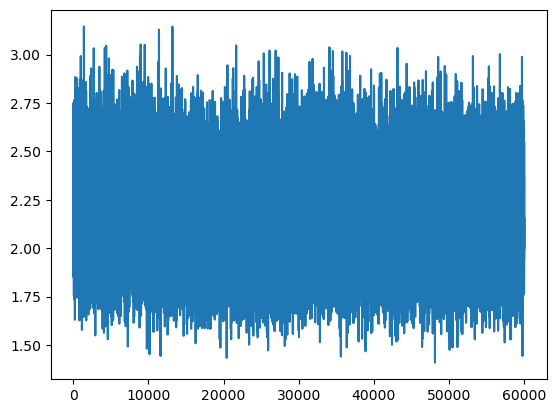

In [23]:
plt.plot(history);

In [19]:
@torch.no_grad()
def eval_dataset(x, y):
    # layer 1
    emb = C[x].view(-1, emb_size * ctx_size)
    
    # layer 2
    pre = emb @ W1
    pre = (pre - bn_mean) / bn_std
    pre = bn_gain * pre + bn_bias
    h = pre.tanh()
    
    # layer 3
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y).item()
    
    return loss

In [24]:
eval_dataset(x_dev, y_dev)

2.1746296882629395

In [25]:
def sample():
    sampl = [0] * ctx_size
    
    with torch.no_grad():
        for _ in range(1000):
            x = torch.tensor([sampl[-3:]])
            emb = C[x].view(-1, emb_size * ctx_size)

            pre = emb @ W1
            pre = (pre - bn_mean) / bn_std
            pre = bn_gain * pre + bn_bias
            h = pre.tanh()
            
            logits = h @ W2 + b2
            prob = F.softmax(logits, dim=1)
            prob = prob[0]
            ix = torch.multinomial(prob, 1).item()
            sampl.append(ix)

            if ix == 0:
                break;

    return "".join([itoc[ix] for ix in sampl[3:-1]])

for _ in range(20):
    print(sample())

jamiah
pry
juemun
kason
lorielysedysh
fariel
beshaison
zala
yoymerravaucksis
katrise
elmoni
aluxe
clar
cramila
tojemon
jert
kaira
tarzilini
jaiyah
nourcelen
